# Create sentence corpus

Let's suppose that we have a hypothesis to pursue like,

    The probabilities of sentence transitions (using base-BERT, not fine-tuned) are higher on fiction than on nonfiction.

I don't think that's actually true; I suspect the reverse is true. But it's a hypothesis you might infer [from existing scholarship,](https://aclanthology.org/2020.acl-main.178/) and in any case it gives us something to test.

Could we even test that kind of hypothesis--with any degree of reliability--using dirty (OCR) texts?

To figure out we need to construct corpora of aligned sentences, and more importantly aligned sentence *pairs*, in both biography and fiction. Then we can measure sentence-transition probabilities in dirty versus clean corpora and see whether the OCR distortion is large enough to interfere problematically with our hypothesis test across the biography/fiction boundary.

This plan means we want to gather texts across a range of OCR qualities, perhaps leaning especially toward the bad side. But we might simply avoid texts with high numbers of ```passagefails``` (alignment problems), because these might be for instance different translations. And in any case, paratext contamination is just not a problem it makes sense to consider for this method. There's no way to compare one pair of sentences with a completely different set of sentences.

So we'll start by pairing our existing statistics on ```worderrors``` and ```passagefails``` with our metadata, in order to choose appropriate volumes. Let's aim for 100 volumes of fiction and 100 of biography. 

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from nltk import tokenize
from collections import Counter
from difflib import SequenceMatcher

### Get metadata

In [3]:
volmeta = pd.read_csv('../metadata/updatedvolumemetadata.tsv', sep = '\t')

In [4]:
volmeta.head()

,docid,author,authordate,title,latestcomp,hathidate,imprint,gutenstring,enumcron,gbindex,...,contents,instances,genre,audience,authgender,multiplehtids,comments,coder,Folder,Trimmed
0,loc.ark+=13960=t5p851b8s,"Reid, Stuart J.",NaN,Lord John Russell,1895,NaN,New York;Harper & brothers;1,"Reid, Stuart J. | Lord John Russell",<blank>,27553,...,NaN,NaN,bio,NaN,u,NaN,NaN,morgan,gutenbiotrimmed,Trimmed
1,hvd.32044070870779,"Smiles, Samuel,",NaN,Lives of the engineers,1879,NaN,London;J. Murray;1874-1877.,"Smiles, Samuel | Lives of the Engineers",v. 5,27710,...,NaN,NaN,bio | short,NaN,m,NaN,"2 people, mixed together (not one per chapter)",morgan,gutenbiotrimmed,Trimmed
2,mdp.39015005892362,"Cruttwell, Maud.",NaN,Luca Signorelli,1899,NaN,London;G. Bell & sons;1899.,"Cruttwell, Maud | Luca Signorelli",<blank>,27759,...,NaN,NaN,bio,NaN,f,NaN,NaN,morgan,gutenbiotrimmed,Trimmed
3,mdp.39015051108531,"Bettany, George Thomas,",NaN,Life of Charles Darwin,1887,NaN,London;W. Scott;1887.,"Bettany, George Thomas | Life of Charles Darwin",<blank>,28380,...,NaN,NaN,bio,NaN,m,NaN,NaN,morgan,gutenbiotrimmed,Trimmed
4,loc.ark+=13960=t6b27z54n,"Gay, Sydney Howard,",NaN,James Madison,1889,NaN,"Boston;New York;Houghton, Mi","Gay, Sydney Howard | James Madison",<blank>,28992,...,NaN,NaN,bio,NaN,u,NaN,NaN,morgan,gutenbiotrimmed,Trimmed


### Get error information

Load our existing information about alignment and then group it by gutenberg index.

In [15]:
errorframes = []
rootpath = '../chunkmismatch/hathinocorrerrs'
for i in range(5):
    path = rootpath + str(i) + '.tsv'
    df = pd.read_csv(path, sep = '\t')
    errorframes.append(df)

error = pd.concat(errorframes, axis = 0)
error.shape

(2624, 3)

In [16]:
error.head()

,chunkid,passagefails,worderrors
0,36958_0,0.01900,0.01423
1,36958_1,0.00392,0.01280
2,36958_2,0.00788,0.01131
3,36958_3,0.01311,0.01050
4,49154_0,0.25348,0.00373


In [17]:
def get_gbindex(filename):
    return filename.split('_')[0]

In [18]:
error['gbindex'] = error.chunkid.map(get_gbindex)

In [19]:
volerror = error.groupby('gbindex').mean()
volerror.head()

,passagefails,worderrors
gbindex,,
1079,0.636145,0.122535
11030,0.050463,0.009663
12259,0.093449,0.132703
12669,0.012843,0.021821
15042,0.040570,0.133600


Let's do a sanity check to make sure I did that correctly.

In [21]:
# sanity check

df = error.loc[error.gbindex == '11030']
df

,chunkid,passagefails,worderrors,gbindex
332,11030_0,0.11391,0.00866,11030
333,11030_1,0.02046,0.01270,11030
334,11030_2,0.02464,0.00742,11030
335,11030_3,0.02640,0.00985,11030
336,11030_4,0.02771,0.00909,11030
337,11030_5,0.08966,0.01026,11030


In [12]:
np.mean(df.worderrors)

0.009663333333333333

Which is what it should be according to the ```volerrors``` frame. We're good.

### Select volumes

We want 100 biography and 100 fiction. To make selection simple let's create a Boolean column.

In [14]:
def isbiography(genretag):
    if genretag.startswith('bio'):
        return True
    else:
        return False

volmeta['isbio'] =  volmeta.genre.map(isbiography)

In [24]:
print('Using all meta we have a frame of shape: ', volmeta.shape)
meta = volmeta.merge(volerror, on = 'gbindex')
print('Using only vols with known error we have: ', meta.shape)

Using all meta we have a frame of shape:  (762, 25)
Using only vols with known error we have:  (423, 27)


In [25]:
print('How many bio?', sum(meta.isbio))

How many bio? 121


<AxesSubplot:xlabel='worderrors', ylabel='Count'>

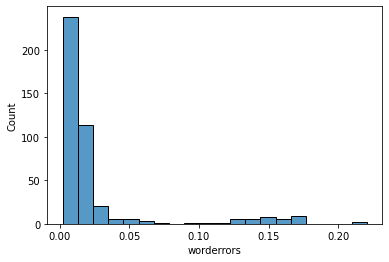

In [27]:
sns.histplot(meta.worderrors, bins = 20)

<AxesSubplot:xlabel='passagefails', ylabel='Count'>

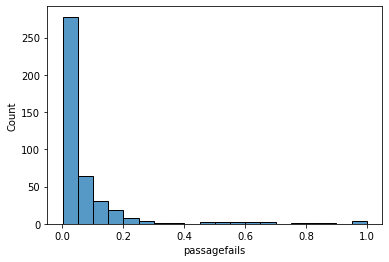

In [28]:
sns.histplot(meta.passagefails, bins = 20)

We want to get rid of books that have too *much* paratextual error or too *little* OCR error.

In [31]:
usablemeta = meta.loc[(meta.passagefails < .25) & (meta.worderrors > .0075), : ]
usablemeta.shape

(316, 27)

In [32]:
sum(usablemeta.isbio)

101

In [33]:
bio = usablemeta.loc[usablemeta.isbio, : ].sample(100)
fic = usablemeta.loc[~usablemeta.isbio, : ].sample(100)

In [34]:
selected = pd.concat([bio, fic], axis = 0)
print(selected.shape)
print(sum(selected.isbio))

(200, 27)
100


In [36]:
print('Mean date of bio is ', np.mean(bio.latestcomp))
print('Mean date of fic is ', np.mean(fic.latestcomp))

Mean date of bio is  1865.37
Mean date of fic is  1856.19


Close enough! We're not training a model to discriminate them.

In [38]:
selected.to_csv('chosenvolumes.tsv', sep = '\t', index = False)

### Get the selected texts

In [39]:
import glob

In [40]:
cleansource = '/Users/tunder/Box Sync/NEHproject/cleannarratives/'
dirtysource = '/Users/tunder/Box Sync/NEHproject/dirtynarratives/'

In [41]:
def get_filestring(pathlist):
    fileparts = []
    
    for filepath in pathlist:
        with open(filepath, encoding = 'utf=8') as f:
            filestring = f.read()
            fileparts.append(filestring)
    
    return ' '.join(fileparts)


def get_connected_texts(gbindex):
    global cleansource, dirtysource
    
    cleantemplate = cleansource + str(gbindex) + '_*.txt'
    cleanfiles = glob.glob(cleantemplate)
    cleanfile = get_filestring(cleanfiles)
    
    dirtytemplate = dirtysource + str(gbindex) + '_*.txt'
    dirtyfiles = glob.glob(dirtytemplate)
    dirtyfile = get_filestring(dirtyfiles)
    
    return dirtyfile, cleanfile


In [42]:
selected.head()

,docid,author,authordate,title,latestcomp,hathidate,imprint,gutenstring,enumcron,gbindex,...,audience,authgender,multiplehtids,comments,coder,Folder,Trimmed,isbio,passagefails,worderrors
414,uva.x000372854,"Coleridge, Samuel Taylor",NaN,Biographia Literaria,1817,1834.0,NaN,NaN,NaN,6081,...,NaN,m,NaN,NaN,NaN,NaN,NaN,True,0.053057,0.020831
68,uc1.b4102292,"Harland, Marion",NaN,Marion Harland's autobiography;,1910,NaN,New York;London;Harper & bro,"Harland, Marion | Marion Harland's Autobiography",<blank>,49003,...,NaN,u,NaN,NaN,wenyi,gutenbiotrimmed,Trimmed,True,0.014142,0.007880
62,uc2.ark+=13960=t6542ns47,"Tyndall, John,",NaN,Hours of exercise in the Alps,1883,NaN,New York;D. Appleton;1883.,"Tyndall, John | Hours of Exercise in the Alps",<blank>,47209,...,NaN,m,NaN,NaN,wenyi,gutenbiotrimmed,Trimmed,True,0.025032,0.018501
59,uc2.ark+=13960=t3cz35s44,"Morlae, Edward",NaN,A soldier of the Legion,1916,1916.0,Boston;New York;Houghton Mif,"Morlae, Edward | A Soldier of the Legion",NaN,46651,...,NaN,m,NaN,NaN,wenyi,gutenbiotrimmed,Trimmed,True,0.094220,0.026580
83,njp.32101067567899,"Cibber, Colley",1671-1757,"An Apology for the Life of Mr. Colley Cibber, ...",1756,1756.0,NaN,NaN,1,44064,...,NaN,m,NaN,NaN,ted,18cgutenbergtrimmed,Trimmed,True,0.168152,0.129347


In [43]:
dirtytext, cleantext = get_connected_texts('6081')

In [44]:
len(dirtytext)

834012

In [45]:
len(cleantext)

830293

In [47]:
dsent = tokenize.sent_tokenize(dirtytext)

In [48]:
len(dsent)

4865

In [52]:
dsent[1]

'For whether there ought to exist\na class of words in the English, in any degree resembling the poetic\n* It is no less an error in teachers, than a torment to the poor children, to en-\nforce the necessity of reading as they would talk.'

In [49]:
dword = tokenize.word_tokenize(dirtytext)
len(dword)

168634

In [53]:
dword[25:60]

['words',
 'themselves',
 '.',
 'For',
 'whether',
 'there',
 'ought',
 'to',
 'exist',
 'a',
 'class',
 'of',
 'words',
 'in',
 'the',
 'English',
 ',',
 'in',
 'any',
 'degree',
 'resembling',
 'the',
 'poetic',
 '*',
 'It',
 'is',
 'no',
 'less',
 'an',
 'error',
 'in',
 'teachers',
 ',',
 'than',
 'a']

In [54]:
positions = [(5, 'old'), (1, 'new'), (3, 'med')]
positions.sort()
positions

[(1, 'new'), (3, 'med'), (5, 'old')]

In [72]:
def get_initial_sentpair(dtext, ctext):
    dwords = tokenize.word_tokenize(dtext)
    cwords = tokenize.word_tokenize(ctext)
    
    positions = []
    cwordcounts = Counter(cwords)
    for word, count in cwordcounts.items():
        if count == 1 and len(word) > 4:
            positions.append((cwords.index(word), word))
    positions.sort()
    
    dsents = tokenize.sent_tokenize(dtext)
    csents = tokenize.sent_tokenize(ctext)
    
    dspos = -1
    cspos = -1
    
    found = False
    
    for position, word in positions:
        if word in dwords:
            keyword = word
            for idx, sentence in enumerate(csents):
                if keyword in sentence:
                    cspos = idx
                    for idx, sentence in enumerate(dsents):
                        if keyword in sentence:
                            dspos = idx
                            sentenceA = csents[cspos]
                            sentenceB = dsents[dspos]
                            matcher = SequenceMatcher(None, sentenceA, sentenceB)
                            if matcher.ratio() > .7:
                                print(dspos, cspos)
                                found = True
                                break
                if found:
                    break
        if found:
            break
        
    
    return dspos, cspos, dsents, csents                
            

In [73]:
dspos, cspos, dsents, csents = get_initial_sentpair(dirtytext, cleantext)

464 2


In [74]:
dsents[dspos]

'If in looking\nthrough all the succeeding volumes the reader should find this a\nsolitary instance, I must submit to that painful forfeiture of esteem,\nwhich awaits a groundless or exaggerated charge.'

In [75]:
csents[cspos]

'If in looking through\n all the succeeding volumes the reader should find this a solitary\n instance, I must submit to that painful forfeiture of esteem, which\n awaits a groundless or exaggerated charge.'

In [127]:
def get_matchqual(sentenceA, sentenceB):
    sentenceA = sentenceA.replace('\n', ' ')
    sentenceB = sentenceB.replace('\n', ' ')
    matcher = SequenceMatcher(None, sentenceA, sentenceB)
    return matcher.ratio()

def get_sentpairs(dtext, ctext):
    
    dpaired = []
    cpaired = []
    
    dspos, cspos, dsents, csents = get_initial_sentpair(dirtytext, cleantext)
    
    matches = 0
    fails = 0
    
    while cspos < len(csents) and dspos < len(dsents) and matches <= 1000:
        
        matchqual = 0
        doffset = 0
        coffset = 0
        matchfail = False
        
        while matchqual < 0.7 and (dspos + doffset) < len(dsents) and (cspos + coffset) < len(csents):
            matchqual = get_matchqual(csents[cspos + coffset], dsents[dspos + doffset])

            if matchqual < .7:
                if not matchfail:
                    # print('Fail clean:', csents[cspos], '\nFail dirty: ', dsents[dspos])
                    matchfail = True
                if doffset < 60:
                    doffset += 1
                else:
                    coffset += 1
                    doffset = 0
                    
        
        if matchfail:
            dpaired.append('<match failed>')
            cpaired.append('<match failed>')
            fails += 1
        
        if (dspos + doffset) >= len(dsents) or (cspos + coffset) >= len(csents):
            break
        
        cspos = cspos + coffset
        dspos = dspos + doffset
        
        dpaired.append(dsents[dspos].replace('\n', ' ').replace('\t', ' ').replace('  ', ' '))
        cpaired.append(csents[cspos].replace('\n', ' ').replace('\t', ' ').replace('  ', ' '))
        
        matches += 1
        
        cspos = cspos + 1
        dspos = dspos + 1
    
    print(matches, " matches, ", fails, " fails.")

    return dpaired, cpaired
    
    

In [123]:
dpairs, cpairs = get_sentpairs(dirtytext, cleantext)

464 2
816  matches,  219  fails.


In [126]:
cpairs[801]

'The word postulate is borrowed from the science  of mathematics [50].'

In [129]:
twentytostart = selected.sample(20)

with open('samplesentences.tsv', mode = 'w', encoding = 'utf-8') as f1:
    f1.write('gbindex\trowctr\tdirty_sentence\tclean_sentence\n')

for idx, row in twentytostart.iterrows():
    gbindex = str(row.gbindex)
    print()
    print('Start ' + gbindex)
    dirtytext, cleantext = get_connected_texts(gbindex)
    if len(dirtytext) < 10:
        continue
    
    dpairs, cpairs = get_sentpairs(dirtytext, cleantext)
    
    ctr = 0
    with open('samplesentences.tsv', mode = 'a', encoding = 'utf-8') as f1:
        for d, c in zip(dpairs, cpairs):
            f1.write(gbindex + '\t' + str(ctr) + '\t' + d + '\t' + c + '\n')
            ctr += 1
    


Start 9609
1714 1767
35  matches,  13  fails.

Start HawkJLSbio
116 2
1001  matches,  245  fails.

Start 39716
18 3
1001  matches,  48  fails.

Start 36160
378 0
921  matches,  77  fails.

Start 34240
150 4
746  matches,  45  fails.

Start 43358
2206 1
291  matches,  48  fails.

Start 37955
75 1
1001  matches,  75  fails.

Start 35119
1 1
1001  matches,  36  fails.

Start 6593
14940 1
19  matches,  11  fails.

Start 40010
81 481
2  matches,  1  fails.

Start 15697
3 1
1001  matches,  125  fails.

Start 46651
26 2
937  matches,  46  fails.

Start 41616
18 0
1001  matches,  29  fails.

Start RereJMHbio
650 0
598  matches,  208  fails.

Start 32835
356 1
846  matches,  101  fails.

Start 44630
1 0
1001  matches,  14  fails.

Start LennCFQ2fic
3 7
1001  matches,  285  fails.

Start CumbRAE2bio
141 67
141  matches,  78  fails.

Start BondWHLbio
157 3
361  matches,  174  fails.

Start 35418
1132 0
1001  matches,  131  fails.


In [130]:
twentytostart.to_csv('sentencemetav1.tsv', sep = '\t', index = False)

In [98]:
cpairs[100]

'Or lastly, the second of the three following stanzas, compared both with  the first and the third.'

In [99]:
dpairs[100]

'Or, lastly, the second of the three following stanzas, compared both with the first and the third.'

In [106]:
sum([True for x in cpairs if x == '<match failed>'])

210

In [107]:
sum([True for x in dpairs if x == '<match failed>'])

210